An example of how I might implement modeling flares in exoplanet

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter

In [2]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(lk.__version__)

0.1.3
1.0.4
3.6
1.0b30.dev


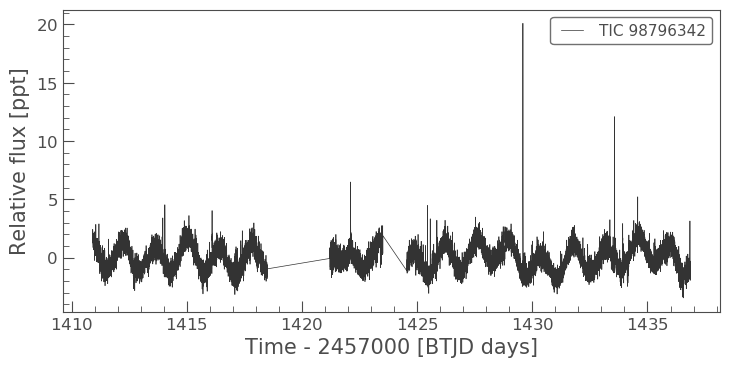

In [9]:
# make a light curve
tpf = lk.TessTargetPixelFile("/home/tom/.lightkurve-cache/mastDownload/TESS/tess2018292075959-s0004-0000000098796342-0124-s/tess2018292075959-s0004-0000000098796342-0124-s_tp.fits")
# tpf = lk.search_targetpixelfile('LTT 1445')
pix_mask = tpf.create_threshold_mask(threshold=2)
corrector = lk.PLDCorrector(tpf)
lc = corrector.correct(aperture_mask=pix_mask, simple_tom=True,
                       cadence_mask=None,
                       use_gp=False)
lc.flux = lc.flux  * 1e3
lc.plot(normalize=False, ylabel='Relative flux [ppt]')


/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


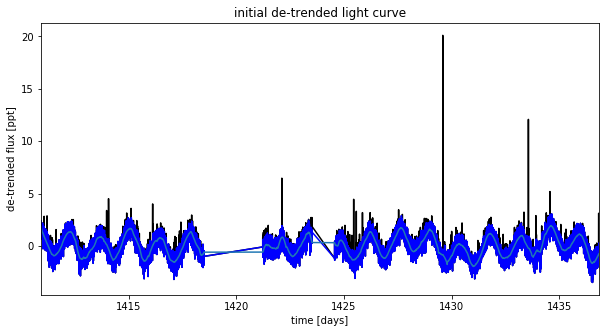

In [10]:
# get a smoothed version of the light curve
smooth = savgol_filter(lc.flux, 301, polyorder=3)
resid = lc.flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "k")
plt.plot(lc.time[mask], lc.flux[mask], "b")
plt.plot(lc.time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(lc.time.min(), lc.time.max());

In [13]:
# find some flares
mflare = resid < 3 * np.sqrt(np.mean(resid**2))
cads = lc.cadenceno - lc.cadenceno[0]
x = lc.time
y = resid #  we're working with the data with a savgol subtracted

fidx = cads[~mflare][:-1][np.diff(cads[~mflare]) < 2]
i = 0
n = 1
while True:
    try:
        if fidx[i + 1] == fidx[i] + n:
            fidx = np.delete(fidx, i + 1)
            n += 1
        else:
            i += 1
            n = 1
    except IndexError:
        break
tpeaks = np.array([lc.time[(lc.cadenceno - lc.cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
ampls = np.ones_like(tpeaks) * 2
fwhms = np.ones_like(ampls) * 0.05
npeaks = np.shape(tpeaks)[0]
print(npeaks)

11


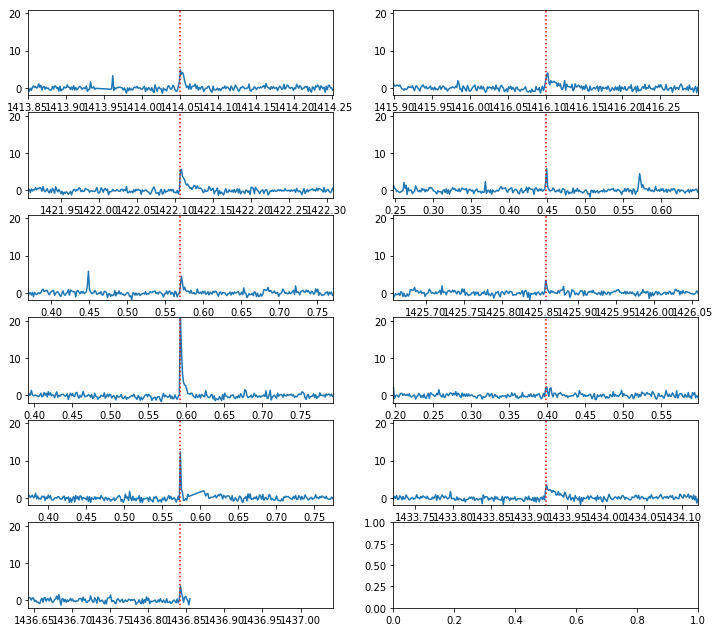

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y), np.max(y))

In [15]:
def multiflaremodel(t, tpeaks, fwhms, ampls, npeaks):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    for i in range(npeaks):
        flare_lc = flaremodel(t, tpeaks[i], fwhm[i], ampl[i])
        multiflare_lc = multiflare_lc + flare_lc
    return multiflare_lc

def flaremodel(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                       (_fr[0] +
                        _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl,
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak),
                       (_fd[0] * tt.exp( ((t - tpeak) / fwhm)*_fd[1] ) +
                        _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
                        ampl,
                        flare_lc
                       )
    return flare_lc

In [16]:
with pm.Model() as model:
    mean = pm.Normal("mean", mu=0, sd=3.0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=5.0)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=0.05, testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(0.001), shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(10*np.var(y)), shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    flare_lc = multiflaremodel(x, tpeak, fwhm, ampl, npeaks)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = pm.find_MAP(start=model.test_point, vars=[fwhm])
    map_soln = pm.find_MAP(start=map_soln, vars=[ampl])
    map_soln = pm.find_MAP(start=map_soln, vars=[fwhm, ampl])

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.3685e+05, ||grad|| = 83.664: 100%|██████████| 21/21 [00:00<00:00, 57.00it/s]  
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.2851e+05, ||grad|| = 145.63: 100%|██████████| 21/21 [00:00<00:00, 71.14it/s]  
/h

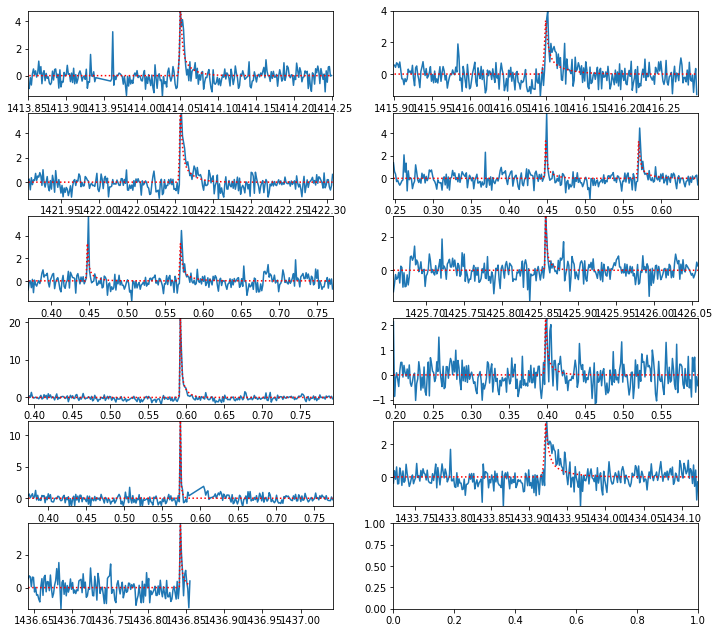

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    ax.plot(x[timemask], map_soln['flare_lc'][timemask], ':r')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))

In [ ]:
sampler = xo.PyMC3Sampler(window=200, start=200, finish=200)
with model:
    burnin = sampler.tune(tune=3000, start=map_soln, step_kwargs=dict(target_accept=0.9))

Sampling 4 chains:  11%|█▏        | 91/808 [02:50<26:57,  2.26s/draws]

In [ ]:
start, step = sampler._get_start_and_step()
with model:
    step = pm.NUTS(potential=step.potential, target_accept=0.9)
    trace = pm.sample(draws=3000, tune=200, step=step, start=start)

In [ ]:
pm.summary(trace, varnames= ['logAmpl', 'logFwhm', 'tpeak', 'logs2', 'mean'], )

In [ ]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
